# Setup/Imports

In [1]:
import pickle
import keras
import tensorflow as tf
from keras import backend as K
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../'))
from helpers.data_generator import process_data, DataGenerator
from helpers.custom_losses import denorm_loss, hinge_mse_loss
from helpers.custom_losses import percent_correct_sign, baseline_MAE
from models.LSTMConv2D import get_model_lstm_conv2d, get_model_simple_lstm
from models.LSTMConv2D import get_model_linear_systems, get_model_conv2d
from utils.callbacks import CyclicLR, TensorBoardWrapper
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from time import strftime, localtime
import matplotlib
from matplotlib import pyplot as plt
import copy

from helpers.normalization import normalize, denormalize, renormalize
#import tkinter as tk
#from tkinter import filedialog
#root = tk.Tk()
#root.withdraw()

Using TensorFlow backend.


In [2]:
%matplotlib inline
font={'family': 'Times New Roman',
      'size': 10}
plt.rc('font', **font)
matplotlib.rcParams['figure.facecolor'] = (1,1,1,1)

# Analysis

In [116]:
file_path='/home/wconlin/run_results/model-conv1d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_07Sep19-15-20_Scenario-120.h5'
model = keras.models.load_model(file_path, compile=False)
print('loaded model: ' + file_path.split('/')[-1])
file_path = file_path[:-3] + '_params.pkl'
with open(file_path, 'rb') as f:
     analysis_params = pickle.load(f, encoding='latin1')
print('loaded dict: ' + file_path.split('/')[-1])
print('with parameters: ' + str(analysis_params.keys()))
locals().update(analysis_params)

loaded model: model-conv1d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_07Sep19-15-20_Scenario-120.h5
loaded dict: model-conv1d_profiles-temp-dens_act-pinj-curr-tinj-gasA_targ-temp-dens_profLB-1_actLB-6_norm-RobustScaler_activ-relu_nshots-12000_ftop-True_07Sep19-15-20_Scenario-120_params.pkl
with parameters: dict_keys(['model_type', 'epochs', 'actuator_names', 'scalar_input_names', 'flattop_only', 'input_profile_names', 'target_profile_names', 'batch_size', 'predict_deltas', 'processed_filename_base', 'normalization_dict', 'rawdata_path', 'sig_names', 'normalization_method', 'window_length', 'window_overlap', 'lookbacks', 'lookahead', 'sample_step', 'uniform_normalization', 'train_frac', 'val_frac', 'nshots', 'efit_type', 'profile_lookback', 'actuator_lookback', 'basefilename', 'profile_downsample', 'model_kwargs', 'std_activation', 'hinge_weight', 'mse_weight_power', 'mse_weight_edge', 'mse_power', 'verb

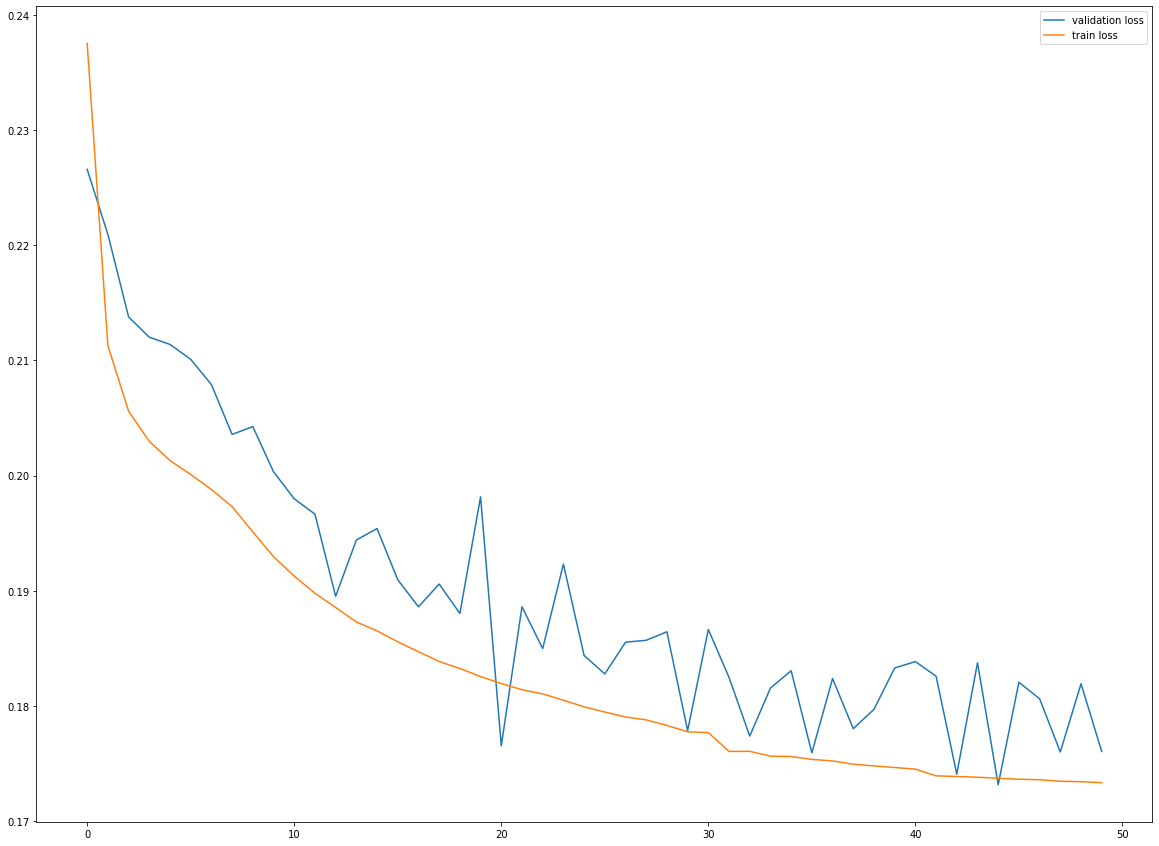

In [117]:
plt.plot(analysis_params['history']['val_loss'],label='validation loss')
plt.plot(analysis_params['history']['loss'],label='train loss')
plt.legend()
#plt.ylim(.25,1)
plt.show()

In [118]:
analysis_params['rawdata'] = '/scratch/gpfs/jabbate/full_data/final_data.pkl'
analysis_params['train_frac'] = 1
analysis_params['val_frac'] = 0
analysis_params['nshots'] = 100
analysis_params['sample_step']=1
analysis_params['shuffle'] = False

analysis_params['processed_filename_base']='/scratch/gpfs/jabbate/data_60_ms_ordered_flattop/'

In [7]:
with open(os.path.join(analysis_params['processed_filename_base'],'train.pkl'),'rb') as f:
    traindata=pickle.load(f,encoding='latin1')
with open(os.path.join(analysis_params['processed_filename_base'],'val.pkl'),'rb') as f:
    valdata=pickle.load(f,encoding='latin1')

In [120]:
analysis_params['batch_size']=1
train_generator = DataGenerator(traindata,**analysis_params)
steps_per_epoch = len(train_generator)

# Design your own shot

In [121]:
plt.rcParams['figure.figsize'] = [20, 15]

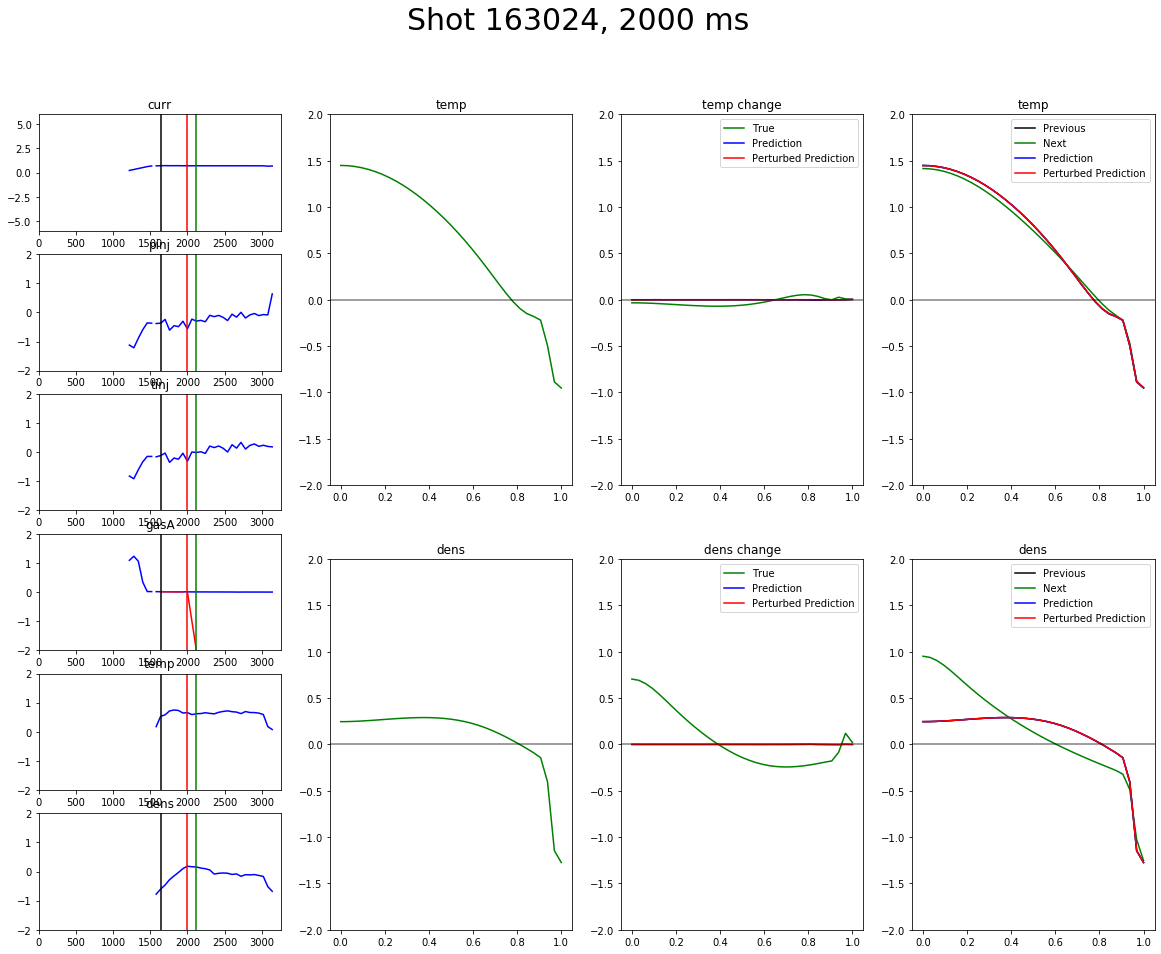

In [126]:
all_shots=np.unique(traindata['shotnum'])
shotnum=np.random.choice(all_shots) #all_shots[5]
t=2000

psi = np.linspace(0,1,profile_length)
sigs=['curr','pinj','tinj','gasA','temp','dens']
profiles=['temp','dens']
input_profiles=['temp','dens'] #['thomson_temp_EFITRT1','thomson_dens_EFITRT1']
changed_input_keys=['gasA']
changed_profile_keys=[] #'thomson_dens_EFITRT1']

shot_indices=np.where(traindata['shotnum'][:,0]==shotnum)[0]

time_offset=np.searchsorted(traindata['time'][shot_indices,-lookahead],t)


#prev_targets=train_generator[shot_indices[0]+time_offset-1][1]

inputs=train_generator[shot_indices[0]+time_offset][0]

changed_input=copy.deepcopy(inputs)
for key in changed_input_keys:
    #changed_input['input_past_{}'.format(key)]=np.array([np.linspace(-2,0,actuator_lookback)])
    #changed_input['input_future_{}'.format(key)]-=[0,.5,1,1.5]
    
    prev=traindata[key][shot_indices[0]+time_offset][-lookahead]
    changed_input['input_future_{}'.format(key)]=np.array([[prev]*lookahead])
    changed_input['input_future_{}'.format(key)]=np.array([np.linspace(prev,prev-2,lookahead)]) 
    #prev=traindata[key][shot_indices[0]+time_offset][-1]#0]
    #changed_input['input_past_{}'.format(key)]=np.array([[prev]*actuator_lookback])

for key in changed_profile_keys:
    #changed_input['input_{}'.format(key)]=np.array([[[0]*profile_length]])
    changed_input['input_{}'.format(key)]-=np.array([[np.linspace(0,1,profile_length)]])
    
targets=train_generator[shot_indices[0]+time_offset][1]

num_cols=4

fig=plt.figure()
for i,sig in enumerate(sigs):
    ax=fig.add_subplot(len(sigs),num_cols,i*num_cols+1)
    if len(traindata[sig][shot_indices].shape)>2:
        ax.plot(traindata['time'][shot_indices,-lookahead],
                np.mean(traindata[sig][shot_indices,-lookahead,:],axis=1),
                c='b')
#         ax.contourf(traindata['time'][shot_indices,-lookahead],
#                 psi,
#                 traindata[sig][shot_indices,-lookahead,::analysis_params['profile_downsample']].T)
        ax.set_ylim(-2,2)
        
    else:
        ax.plot(traindata['time'][shot_indices[0],:-lookahead],
                        traindata[sig][shot_indices[0],:-lookahead],
               c='b')
        ax.plot(traindata['time'][shot_indices,-lookahead],
                        traindata[sig][shot_indices,-lookahead],
               c='b')
        if sig in changed_input_keys:
            ax.plot(traindata['time'][shot_indices[0]+time_offset,-lookahead:],
                   changed_input['input_future_{}'.format(sig)].squeeze(),
                   color='r')
            ax.plot(traindata['time'][shot_indices[0]+time_offset,:-lookahead],
                   changed_input['input_past_{}'.format(sig)].squeeze(),
                   color='r')
        if sig=='curr':
            ax.set_ylim(-6,6)
        else:
            ax.set_ylim(-2,2)
        
    
    ax.axvline(traindata['time'][shot_indices[0]+time_offset,-lookahead],
              color='r')
    ax.axvline(traindata['time'][shot_indices[0]+time_offset,-1],
              color='g')
    ax.axvline(traindata['time'][shot_indices[0]+time_offset,0],
              color='k')
    ax.set_xlim(0,np.amax(traindata['time'][shot_indices]))
    ax.set_title(sig)

# truths=train_generator[shot_indices[0]+time_offset][1]

for i,profile in enumerate(input_profiles):
    ax=fig.add_subplot(len(input_profiles),num_cols,i*num_cols+1+1)
    
    ax.plot(psi,inputs['input_{}'.format(profile)].squeeze(),c='g')
    if profile in changed_profile_keys:
        ax.plot(psi,changed_input['input_{}'.format(profile)].squeeze(),c='r')
    ax.set_title('{}'.format(profile))
    ax.axhline(0,color='k',alpha=.5)
    ax.set_ylim(-2,2)

predictions=model.predict_on_batch(inputs)
changed_predictions=model.predict_on_batch(changed_input)
for i,profile in enumerate(profiles):
    ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1+1)
    ax.plot(psi,targets['target_{}'.format(profile)].squeeze(),label='True',c='g')
    ax.plot(psi,predictions[i].squeeze(),label='Prediction',
            c='b')
    if len(changed_input_keys)>0:
        ax.plot(psi,changed_predictions[i].squeeze(),color='r',label='Perturbed Prediction')
    ax.set_title('{} change'.format(profile))
    ax.axhline(0,color='k',alpha=.5)
    ax.set_ylim(-2,2)
    ax.legend()
    
    ax=fig.add_subplot(len(profiles),num_cols,i*num_cols+1+1+1+1)
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][0][::analysis_params['profile_downsample']],
            label='Previous',
            c='k')
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][-1][::analysis_params['profile_downsample']],
            label='Next',
            c='g')
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][0][::analysis_params['profile_downsample']]+predictions[i].squeeze(),
            label='Prediction',
            c='b')
    ax.plot(psi,
            traindata[profile][shot_indices[0]+time_offset][0][::analysis_params['profile_downsample']]+changed_predictions[i].squeeze(),
            label='Perturbed Prediction',
            c='r')
    ax.legend()
    ax.set_title(profile)
    ax.set_ylim(-2,2)
    ax.axhline(0,color='k',alpha=.5)
    
time=train_generator.cur_times[:,max(profile_lookback, actuator_lookback)].squeeze()
fig.suptitle('Shot {:.0f}, {:.0f} ms'.format(shotnum,time),fontsize=30)
plt.subplots_adjust(hspace=.2)
plt.show()